<a href="https://colab.research.google.com/github/vasudev-sharma/Brain-Tumor-Segmentation/blob/master/ML_interns_interview_v2_Vasudev_Sharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem statement
* given a dataset containing mostly MNIST digit [7] but also some [0, 1, 2, 3, 4, 5, 6, 8, 9] develop a method to detect digits that aren't 7s

### imports and helper functions

In [38]:
# setup
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.metrics import (average_precision_score, precision_recall_curve, 
                             PrecisionRecallDisplay,
                             confusion_matrix, ConfusionMatrixDisplay)



In [39]:
# Constants

INLIER_DIGIT = 7
OUTLIER_DIGITS = list(range(10))
OUTLIER_DIGITS.remove(INLIER_DIGIT)
OUTLIER_SAMP_SIZE = .05 # about 10% of other digits

In [40]:
# some helper functions 

def load_mnist_csvs(dataset_path):
  
  dataset = pd.read_csv(dataset_path,header=None)
  labels = dataset[0]
  features = dataset[list(range(1,785))]
  
  return {'features': features.values, 'labels': labels.values}

def plot_dataset(dataset, num_samps = 16):

  if len(dataset['labels'])<num_samps:
    num_samps = len(dataset)
  dim = int(np.ceil(np.sqrt(num_samps)))
  plt.figure(figsize=(10,10))
  
  for i in range(num_samps):
    plt.subplot(dim,dim,i+1)
    plt.imshow(dataset['features'][i].reshape(28,28), 'gray')
    plt.title(dataset['labels'][i])
    plt.axis('off')

def combine_datasets(datasets, shuffle=True):
  out_features = [x['features'] for x in datasets]
  out_labels = [x['labels'] for x in datasets]

  out_features = np.concatenate(out_features)
  out_labels = np.concatenate(out_labels)

  shuffle_ind = list(range(len(out_features)))
  np.random.shuffle(shuffle_ind)
 
  return({'features': out_features[shuffle_ind],
          'labels': out_labels[shuffle_ind]})

def get_outlier_samples(dataset, outlier_sample_percentage):
  out_datasets = []
  for i in OUTLIER_DIGITS:
    num_samps_i = (dataset['labels']==i).sum()
    ix_size = int(num_samps_i * outlier_sample_percentage)
    ix = np.random.choice(num_samps_i, size=ix_size, replace=False)
    features_i = dataset['features'][dataset['labels']==i][ix]
    out_datasets.append({'features':features_i,
                         'labels':[i] * ix_size})
  return combine_datasets(out_datasets)

def plot_average_precision_curve(dataset, scores, series_name=''):

  display = PrecisionRecallDisplay.from_predictions(
      dataset['labels']!=INLIER_DIGIT, 
      scores, 
                  name=series_name)
  _ = display.ax_.set_title("2-class Precision-Recall curve")
  plt.ylim(0,1)

def get_pred_from_score_at_recall(dataset, scores, recall_thresh=.5):
  p,r,t = precision_recall_curve(dataset['labels']!=INLIER_DIGIT, scores)
  thresh = t[r[:-1]>recall_thresh][-1]
  return scores>thresh

def plot_confusion_matrix(dataset, preds):

  conf_mat = confusion_matrix(dataset['labels']!=INLIER_DIGIT, preds)
  ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                       display_labels=['inliers','outliers']).plot()
  print('inlier_acc = ',(np.diag(conf_mat)/conf_mat.sum(1))[0])
  print(np.diag(conf_mat)/conf_mat.sum(1))



### Dataset setup and visualization

In [41]:
# set up datasets

mnist_train = load_mnist_csvs('./sample_data/mnist_train_small.csv')
mnist_val = load_mnist_csvs('./sample_data/mnist_test.csv')

mnist_train_inliers = {'features': mnist_train['features'][mnist_train['labels'] == INLIER_DIGIT], 
                     'labels': mnist_train['labels'][mnist_train['labels'] == INLIER_DIGIT]}
mnist_val_inliers = {'features': mnist_val['features'][mnist_val['labels'] == INLIER_DIGIT], 
                     'labels': mnist_val['labels'][mnist_val['labels'] == INLIER_DIGIT]}

mnist_train_outliers = get_outlier_samples(mnist_train, OUTLIER_SAMP_SIZE)
mnist_val_outliers = get_outlier_samples(mnist_val, OUTLIER_SAMP_SIZE)

train_dataset = combine_datasets([mnist_train_inliers, mnist_train_outliers])
val_dataset = combine_datasets([mnist_val_inliers, mnist_val_outliers])

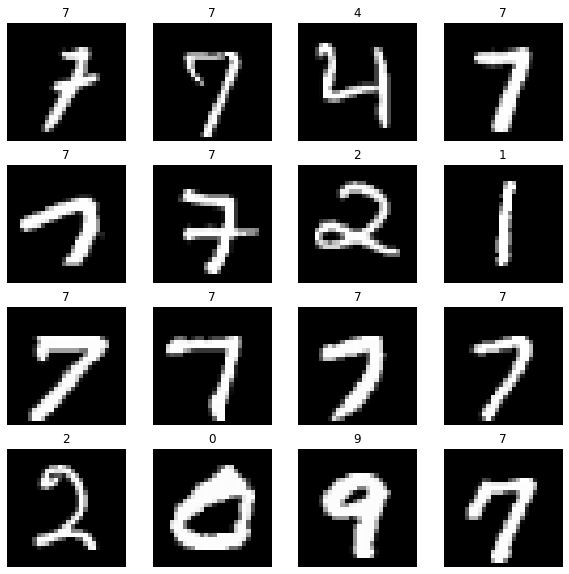

In [42]:
plot_dataset(train_dataset)

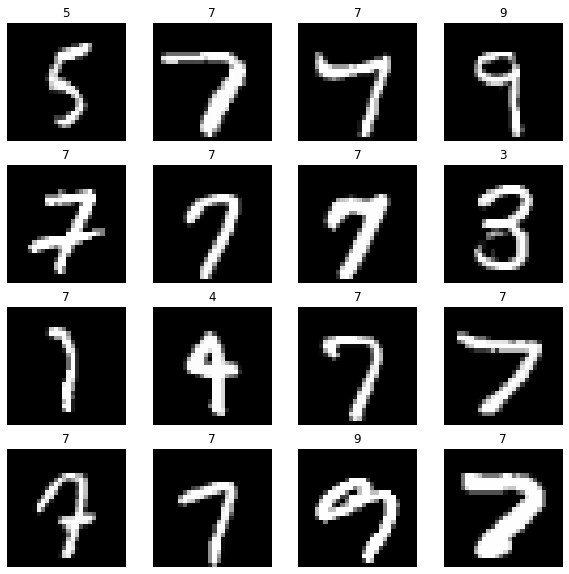

In [43]:
plot_dataset(val_dataset)

Text(0.5, 1.0, 'train dist')

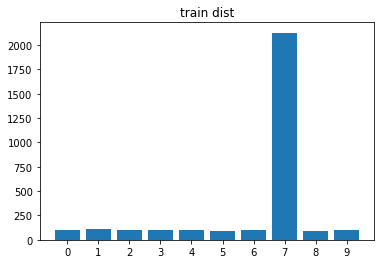

In [44]:
plt.bar(list(range(10)),[(train_dataset['labels']==i).sum() for i in range(10)])
plt.xticks(np.array(range(10)),range(10))
plt.title('train dist')

In [45]:
# TSNE of train data
X = train_dataset['features']
tsne_fit = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(X)

Text(0.5, 1.0, 'detecting outlier')

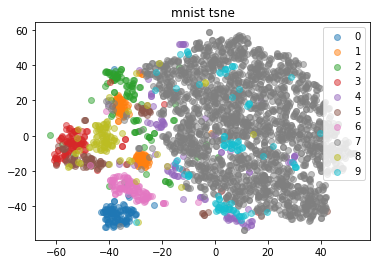

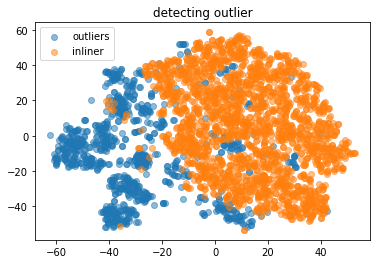

In [46]:
for i in range(0,10):
  plt.scatter(tsne_fit[train_dataset['labels']==i][:,0],
              tsne_fit[train_dataset['labels']==i][:,1],alpha=.5)
plt.legend(range(0,10))
plt.title('mnist tsne')

plt.figure()
plt.scatter(tsne_fit[train_dataset['labels']!=INLIER_DIGIT][:,0],
            tsne_fit[train_dataset['labels']!=INLIER_DIGIT][:,1],alpha=.5)
plt.scatter(tsne_fit[train_dataset['labels']==INLIER_DIGIT][:,0],
            tsne_fit[train_dataset['labels']==INLIER_DIGIT][:,1],alpha=.5)
plt.legend(['outliers','inliner'])
plt.title('detecting outlier')

### one class SVM benchmark

In [47]:
scaler = MinMaxScaler()
scaler.fit(train_dataset['features'])

X = scaler.transform(train_dataset['features'][:,:])
clf = OneClassSVM(gamma='auto',nu=.5).fit(X)

In [48]:
mnist_train_pred = clf.predict(scaler.transform(train_dataset['features']))
mnist_train_score =clf.score_samples(scaler.transform(train_dataset['features']))

mnist_val_pred = clf.predict(scaler.transform(val_dataset['features']))
mnist_val_score =clf.score_samples(scaler.transform(val_dataset['features']))


inlier_acc =  0.09642521166509878
[0.09642521 0.49943883]
inlier_acc =  0.08657587548638132
[0.08657588 0.5       ]


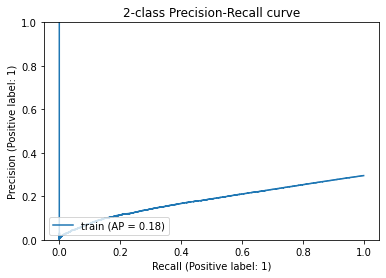

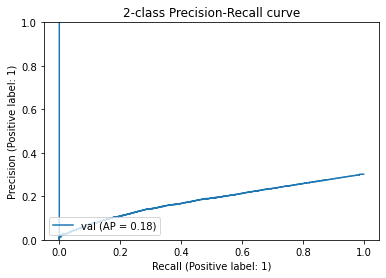

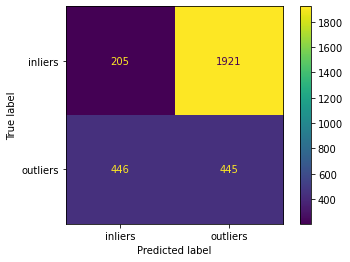

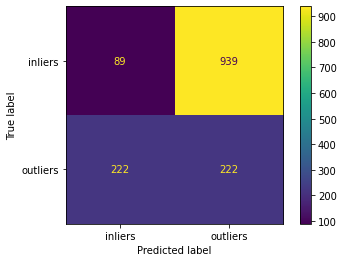

In [49]:
plot_average_precision_curve(train_dataset, mnist_train_score, series_name='train')
plot_average_precision_curve(val_dataset, mnist_val_score, series_name='val')

train_pred_r50 = get_pred_from_score_at_recall(train_dataset,mnist_train_score,0.5)
val_pred_r50 = get_pred_from_score_at_recall(val_dataset,mnist_val_score,0.5)

plot_confusion_matrix(train_dataset, train_pred_r50)
plot_confusion_matrix(val_dataset, val_pred_r50)

### train simple embedding network

train Auto Encoder model to learn feature space

In [77]:
# imports 
import torch.nn as nn
import torch

# from torchvision import transforms



In [63]:

# Training
train_dataset_features = torch.from_numpy(train_dataset['features']).float()
train_dataset_labels = torch.from_numpy(train_dataset['labels']).float()

# Validation
val_dataset_features = torch.from_numpy(val_dataset['features']).float()
val_dataset_labels = torch.from_numpy(val_dataset['labels']).float()




In [64]:



from torch.utils.data import TensorDataset, DataLoader
# Dataset 
train_ds = TensorDataset(train_dataset_features,train_dataset_features) 
val_ds = TensorDataset(val_dataset_features,val_dataset_features) 
# val_ds = TensorDataset(val_dataset['features'], val_dataset['labels'])


In [65]:
# Train and Val Dataloader

batch_size = 16
train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size)
val_dl = DataLoader(val_ds, shuffle=False, batch_size=batch_size)

Object `TensorDataset` not found.


In [70]:
# net defition
class AutoEncoder(nn.Module):
  def __init__(self, num_features):
    super(AutoEncoder, self).__init__()
    self.features = num_features
    self.encoder = nn.Sequential(
        nn.Linear(self.features, self.features*2), 
        nn.ReLU(),
        nn.Linear(self.features*2,self.features*4),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.features*4, self.features*2), 
        nn.ReLU(),
        nn.Linear(self.features*2,self.features),
        nn.ReLU()
    )

    
    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x


In [72]:
# Define model
model = AutoEncoder(784)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=1568, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1568, out_features=3136, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=3136, out_features=1568, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1568, out_features=784, bias=True)
    (3): ReLU()
  )
)

In [75]:
# optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.()

In [76]:
# training loop
model_epochs = 10
for epoch in range(1, model_epochs +1):

  # Train Data Loader
  loss_sum = 0
  model.train()
  for step, (features, labels) in enumerate(train_dl, 1):
    
    optimizer.zero_grad()

    # Forward Pass
    predictions = model(features)
    loss = criterion(predictions, features)
    loss_sum += loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()

  # Validation Dataloader
  val_loss_sum = 0
  model.eval()
  for val_step, (features, labels) in enumerate(val_dl, 1):
    with torch.no_grad:

      # Forward Pass
      predictions = model(features)
      val_loss = criterion(predictions, labels)
      val_loss_sum += val_loss.item()

 

NotImplementedError: ignored

In [ ]:
# produce scores

#train_scores
#val_scores

### Evaluate

In [ ]:
plot_average_precision_curve(train_dataset, train_scores, series_name='train')
plot_average_precision_curve(val_dataset, val_scores, series_name='val')

deep_train_pred_r50 = get_pred_from_score_at_recall(train_dataset,train_scores,0.5)
deep_val_pred_r50 = get_pred_from_score_at_recall(val_dataset,val_scores,0.5)

plot_confusion_matrix(train_dataset, deep_train_pred_r50)
plot_confusion_matrix(val_dataset, deep_val_pred_r50)